In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from pykrige.rk import RegressionKriging
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging

import warnings
warnings.simplefilter(action='ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [4]:
"""
Удаление выбросов с использованием межквартильного размаха (IQR)
"""
def get_filter_df(df, col):
    # Определяем Q1 и Q3 квартили
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    
    # Вычисляем IQR
    IQR = Q3 - Q1
    
    # Определяем границы для определения выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Фильтруем выбросы
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [57]:
"""
Отсортировать 2d-массив 
"""
def sort_2d_by_distance(start, data):
    points = data[:, :2]
    start_point = points[start]

    distances = []
    for i in range(points.shape[0]):
        distances.append(np.linalg.norm(points[i] - start_point))

    sorted_indices = np.argsort(distances)
    return data[sorted_indices], np.max(distances)


A = np.array([[1, 2, 3], 
              [4, 5, 6], 
              [7, 8, 9], 
              [10, 11, 12]
             ]
            )
sort_2d_by_distance(3, A)

(array([[10, 11, 12],
        [ 7,  8,  9],
        [ 4,  5,  6],
        [ 1,  2,  3]]),
 12.727922061357855)

In [78]:
"""
Функция создает последовательный список комбинаций созданных по входным значениям
"""
def get_list_point(lst):
    lst = np.array(lst)
    
    if len(lst) < 3:
        return [[lst[0], lst[1]]]
    else:
        out = []
        length = len(lst)-1
        steps = []
        while length > 0:
            steps.append(length)
            length = length//2
        #print(steps)
        length = len(lst)
        indexs = []
        len_before = 1
        for i in steps:
            for j in range(0, length, i):
                indexs.append(j)
                if len_before < len(np.unique(indexs)):
                    out.append(lst[np.unique(indexs)])
                    len_before = len(np.unique(indexs))
    return out
    
get_list_point(list(range(10, 51, 10)))

[array([10, 50]),
 array([10, 30, 50]),
 array([10, 20, 30, 50]),
 array([10, 20, 30, 40, 50])]

In [8]:
def my_R2(y_true, y_pred, y_mean):
    """
    R2 в котором mse считается относительно среднего здачения тренировочных данных, а не тестовых данных
    """
    mse1 = mean_squared_error(y_true, y_pred)
    mse2 = mean_squared_error(y_true, [y_mean] * y_true.shape[0])
    return 1 - mse1/mse2

# example
y1 = np.array([1, 2, 3, 4, 5])
y2 = np.array([2, 2, 2, 4, 6])
print(r2_score(y1, y2), my_R2(y1, y2, np.mean(y1)))
print(r2_score(y1, [np.mean(y2)]*y1.shape[0]), my_R2(y1, [np.mean(y2)]*y1.shape[0], np.mean(y2)))

0.7 0.7
-0.020000000000000018 0.0


In [82]:
class R2FunctionForKrigin():

    def __init__(self, df):
        self.df = df

    def get_dict_R2_for_UK(self, df, list_boreholes, variograma='exponential'):
        """
        Получить словарь со значения R2 для разного размера тренировочной выборки
        """
        list_boreholes_train = get_list_point(list_boreholes)
        result_r2_count = {}
        
        for boreholes_train in list_boreholes_train:
            """
            Разбивка определенных скважин
            """
            data_train = df.query('borehole in @boreholes_train')
            data_test = df.query('borehole not in @boreholes_train')
        
            if data_test.shape[0] == 0:
                continue
        
            p_train = data_train.loc[:, ["x", "y"]].to_numpy()
            p_test = data_test.loc[:, ["x", "y"]].to_numpy()
            x_train = data_train.loc[:, ["x", "y"]].to_numpy()
            x_test = data_test.loc[:, ["x", "y"]].to_numpy()
            target_train = data_train.loc[:, ["E"]].to_numpy().reshape(-1)
            target_test = data_test.loc[:, ["E"]].to_numpy().reshape(-1)
            
            """
            Кригинг
            """
            x = x_train[:, 0]
            y = x_train[:, 1]
            E = target_train
        
            UK = UniversalKriging(x, 
                                  y, 
                                  E, 
                                  variogram_model=variograma,
                                 )
            predict_test, var_test = UK.execute('points', x_test[:, 0], x_test[:, 1])
            result_r2_count[len(boreholes_train)] = [r2_score(target_test, predict_test), my_R2(target_test, predict_test, np.mean(target_train))]
    
        return result_r2_count

    def show_func(self, list_boreholes):
        plt.figure(figsize=(8, 4))
        plt.title('Изменение качества модели с уменьшением количества модельных данных')
        plt.xlabel('Количество модельных данных')
        plt.ylabel('Коэф. Детерминации')
        plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        plt.minorticks_on()
        plt.axhspan(0, -1, color='red', alpha=0.05)
        plt.axhspan(1, 0, color='green', alpha=0.05)
        
        for i in range(len(list_boreholes)):
            list_boreholes_now = list_boreholes[i]
            df_now = self.df.query('borehole in @list_boreholes_now')
            
            result_r2_count = self.get_dict_R2_for_UK(df_now, list_boreholes_now, variograma='exponential')
            
            df_r2_count = pd.DataFrame(result_r2_count, index=["R2", "R2_train"]).applymap(lambda x: round(x, 3)).T
            df_r2_count["count"] = df_r2_count.index
            df_r2_count = df_r2_count.applymap(lambda x: -1.1 if x < -1.1 else x)
            
            df_r2_count = df_r2_count.sort_values(by="count")
            plt.plot(df_r2_count["count"], df_r2_count["R2"], "--*", label=f"{i}")
            
        plt.legend()    
        plt.show()    
        

def get_dict_R2_for_UK(df, list_boreholes, variograma='exponential'):
    """
    Получить словарь со значения R2 для разного размера тренировочной выборки
    """
    list_boreholes_train = get_list_point(list_boreholes)
    result_r2_count = {}
    
    for boreholes_train in list_boreholes_train:
        """
        Разбивка определенных скважин
        """
        data_train = df.query('borehole in @boreholes_train')
        data_test = df.query('borehole not in @boreholes_train')
    
        if data_test.shape[0] == 0:
            continue
    
        p_train = data_train.loc[:, ["x", "y"]].to_numpy()
        p_test = data_test.loc[:, ["x", "y"]].to_numpy()
        x_train = data_train.loc[:, ["x", "y"]].to_numpy()
        x_test = data_test.loc[:, ["x", "y"]].to_numpy()
        target_train = data_train.loc[:, ["E"]].to_numpy().reshape(-1)
        target_test = data_test.loc[:, ["E"]].to_numpy().reshape(-1)
        """
        Кригинг
        """
        x = x_train[:, 0]
        y = x_train[:, 1]
        E = target_train
    
        OK = UniversalKriging(x, 
                              y, 
                              E, 
                              variogram_model=variograma,
                              #variogram_parameters={'sill':28, 'range': 50, 'nugget': 1}
                             )
        predict_test, var_test = OK.execute('points', x_test[:, 0], x_test[:, 1])
        result_r2_count[len(boreholes_train)] = [r2_score(target_test, predict_test), my_R2(target_test, predict_test, np.mean(target_train))]

    return result_r2_count

## Разбивка данных

In [74]:
"""
Чтение информации о скважинах
"""
df_boreholes = df_boreholes = pd.read_excel(f"data/координаты_скважин.xlsx")
house_3 = pd.read_excel("data/house_3_local.xlsx")

all_E = pd.DataFrame(columns=["borehole", "x", "y", "z", "h", "E"])

for borehole in house_3["тсз"]:
    """
    Запись данных по скважинам в один датафрейм
    """
    borehole_info = house_3[house_3["тсз"]==borehole]
    df_now = pd.read_excel(f"data/тсз{borehole}.xlsx")
    df_now = get_filter_df(df_now, "E").loc[:, ["h", "E"]]
    
    df_now["borehole"] = borehole 
    df_now["x"] = borehole_info["x"].iloc[0]
    df_now["y"] = borehole_info["y"].iloc[0]
    df_now["z"] = borehole_info["z"].iloc[0]

    all_E = pd.concat([all_E, df_now], ignore_index=True)

all_E["z_h"] = all_E["z"] - all_E["h"]
print(all_E.head(), all_E.shape)

"""
Деление без остатка абсолютной отметки на 1 и запись значение в 'group'
группировка и вычисление средних значений
"""
all_E["group"] = all_E["z_h"]//1
group_E = all_E.groupby(by=["group", "borehole"]).mean()
group_E["group"] = [int(x[0]) for x in group_E.index]
group_E["borehole"] = [int(x[1]) for x in group_E.index]

"""
Коэф. перехода значений X и Y к размерам реального фундамента, при условии что крайние точки лежат на периметре фундамента
"""
coeff_dist_Y = 26/np.linalg.norm(house_3.query("тсз == 59").loc[:, ["x", "y"]].to_numpy() - house_3.query("тсз == 51").loc[:, ["x", "y"]].to_numpy())
coeff_dist_X = 25/np.linalg.norm(house_3.query("тсз == 123").loc[:, ["x", "y"]].to_numpy() - house_3.query("тсз == 51").loc[:, ["x", "y"]].to_numpy())

  borehole             x            y       z     h    E     z_h
0       51  97607.570697  4338.997129  76.631  0.00  0.0  76.631
1       51  97607.570697  4338.997129  76.631  0.05  6.0  76.581
2       51  97607.570697  4338.997129  76.631  0.10  6.0  76.531
3       51  97607.570697  4338.997129  76.631  0.15  6.0  76.481
4       51  97607.570697  4338.997129  76.631  0.20  6.0  76.431 (24429, 7)


In [10]:
"""
Линия X
"""
list_x = []

boreholes_line = list(range(51, 60)) + list(range(132, 136))
list_x.append(boreholes_line)

for i in range(7):
    boreholes_line = list(range(i*9+60, i*9+69))
    list_x.append(boreholes_line)

boreholes_line = list(range(123, 132)) + list(range(144, 148))
list_x.append(boreholes_line)

"""
Линия Y
"""
list_y = []

boreholes_line = list(range(51, 124, 9)) + list(range(140, 144))
list_y.append(boreholes_line)

for i in range(7):
    boreholes_line = list(range(i+52, i+125, 9))
    list_y.append(boreholes_line)

boreholes_line = list(range(59, 132, 9)) + list(range(136, 140))
list_y.append(boreholes_line)

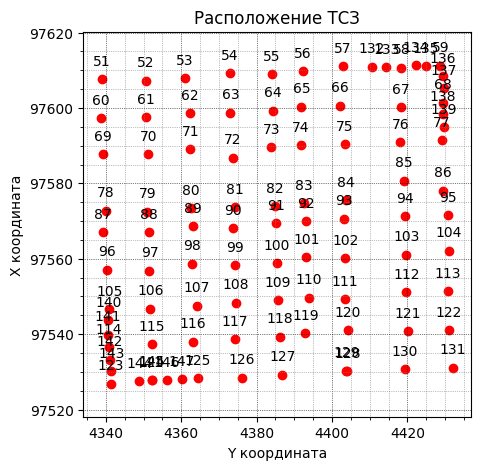

In [11]:
boreholes_line = range(160)

df_now = house_3.query("тсз in @boreholes_line").reset_index(drop=True)

plt.figure(figsize=(5, 5))
y = df_now["x"]
x = df_now["y"]
labels = df_now["тсз"]
for i in range(len(x)):
    plt.scatter(x[i], y[i], label=f'{labels[i]} ({x[i]}, {y[i]})', color="red")
    plt.annotate(labels[i], (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Расположение ТСЗ')
plt.xlabel('Y координата')
plt.ylabel('X координата')
plt.axis('equal')
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.show()

## Определение оптимальных точек вдоль оси Х

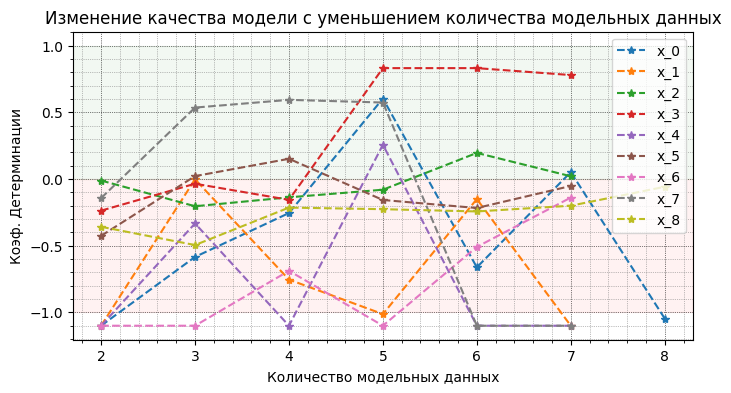

In [12]:
"""
Качество модели при разном числе точек вдоль горизонтальной оси Х на графике (оси Y в df)
    Тренировочная выборка - рассматривается первая линия
    Тестовая выборка - оставшиеся точки из 1ой линии
"""
model = 'exponential'

plt.figure(figsize=(8, 4))
plt.title(f'Изменение качества модели с уменьшением количества модельных данных')
plt.xlabel('Количество модельных данных')
plt.ylabel('Коэф. Детерминации')
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.axhspan(0, -1, color='red', alpha=0.05)
plt.axhspan(1, 0, color='green', alpha=0.05)

for i in range(len(list_x)):
    list_x_now = list_x[i]
    list_boreholes_train = get_list_point(list_x_now)
    result_r2_count = {}

    df_now = group_E.query('group == 65')
    df_now = df_now.query('borehole in @list_x_now')
    
    for boreholes_train in list_boreholes_train:
        """
        Разбивка определенных скважин
        """
        data_train = df_now.query('borehole in @boreholes_train')
        data_test = df_now.query('borehole not in @boreholes_train')
    
        if data_test.shape[0] == 0:
            continue
    
        p_train = data_train.loc[:, ["x", "y"]].to_numpy()
        p_test = data_test.loc[:, ["x", "y"]].to_numpy()
        x_train = data_train.loc[:, ["x", "y"]].to_numpy()
        x_test = data_test.loc[:, ["x", "y"]].to_numpy()
        target_train = data_train.loc[:, ["E"]].to_numpy().reshape(-1)
        target_test = data_test.loc[:, ["E"]].to_numpy().reshape(-1)
        
        """
        Кригинг
        """
        x = [0]*x_train[:, 1].shape[0] #x_train[:, 0]
        y = x_train[:, 1]
        E = target_train

        #print(i, len(boreholes_train), len(x), x_train.shape, E.shape, boreholes_train)
        OK = UniversalKriging(x, y, E, variogram_model=model, 
                              #variogram_parameters={'sill':28, 'range': 50, 'nugget': 1}
                             )
    
        predict_test, var_test = OK.execute('points', [0]*x_test[:, 1].shape[0], x_test[:, 1])
        result_r2_count[len(boreholes_train)] = [r2_score(target_test, predict_test), my_R2(target_test, predict_test, np.mean(target_train))]

    df_r2_count = pd.DataFrame(result_r2_count, index=["R2", "R2_train"]).applymap(lambda x: round(x, 3)).T
    df_r2_count["count"] = df_r2_count.index
    df_r2_count = df_r2_count.query("count < 9")
    df_r2_count = df_r2_count.applymap(lambda x: -1.1 if x < -1.1 else x)
    
    df_r2_count = df_r2_count.sort_values(by="count")
    plt.plot(df_r2_count["count"], df_r2_count["R2"], "--*", label=f"x_{i}")
    
plt.legend()    
plt.show()

длина ряда точек: 26.229285782598037
длина ряда точек: 26.28868957271061
длина ряда точек: 26.284597648800524
длина ряда точек: 26.274189369572756
длина ряда точек: 26.60823338121661
длина ряда точек: 26.244307656008687
длина ряда точек: 26.11863155215638
длина ряда точек: 26.486451247177953


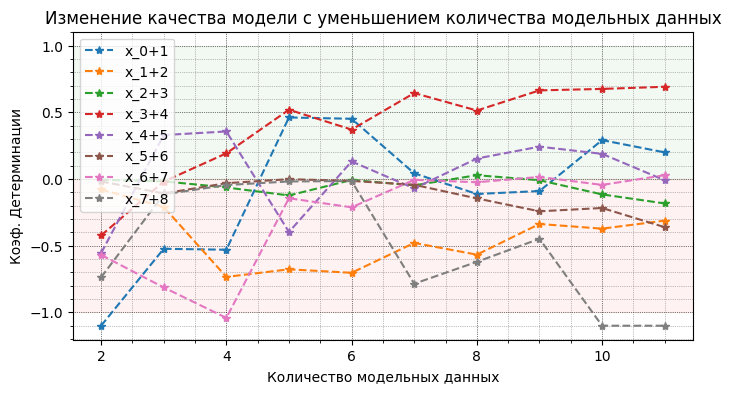

In [75]:
"""
Качество модели при разном числе точек вдоль горизонтальной оси Х на графике (оси Y в df)
    Тренировочная выборка - рассматривается первая линия и вторая линия
    Тестовая выборка - оставшиеся точки из линий
"""
model = 'exponential'

plt.figure(figsize=(8, 4))
plt.title(f'Изменение качества модели с уменьшением количества модельных данных')
plt.xlabel('Количество модельных данных')
plt.ylabel('Коэф. Детерминации')
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.axhspan(0, -1, color='red', alpha=0.05)
plt.axhspan(1, 0, color='green', alpha=0.05)

for i in range(len(list_x)-1):
    """
    Сортировка номеров скважин в двух рядах по расстоянию
    """
    list_x_now = list_x[i] + list_x[i+1]
    points = house_3.query('тсз == @list_x_now').sort_values(by="тсз").reindex(columns=["x", "y", "z", "тсз"])
    list_x_now, max_distance = sort_2d_by_distance(0, points.to_numpy())
    list_x_now = list_x_now[:, -1]
    max_distance *= coeff_dist_Y
    

    
    list_boreholes_train = get_list_point(list_x_now)
    result_r2_count = {}

    df_now = group_E.query('group == 65')
    df_now = df_now.query('borehole in @list_x_now')
    
    for boreholes_train in list_boreholes_train:
        """
        Разбивка определенных скважин
        """
        data_train = df_now.query('borehole in @boreholes_train')
        data_test = df_now.query('borehole not in @boreholes_train')
    
        if data_test.shape[0] == 0:
            continue
    
        p_train = data_train.loc[:, ["x", "y"]].to_numpy()
        p_test = data_test.loc[:, ["x", "y"]].to_numpy()
        x_train = data_train.loc[:, ["x", "y"]].to_numpy()
        x_test = data_test.loc[:, ["x", "y"]].to_numpy()
        target_train = data_train.loc[:, ["E"]].to_numpy().reshape(-1)
        target_test = data_test.loc[:, ["E"]].to_numpy().reshape(-1)
        
        """
        Кригинг
        """
        x = x_train[:, 0]
        y = x_train[:, 1]
        E = target_train

        #print(i, len(boreholes_train), len(x), x_train.shape, E.shape, boreholes_train)
        OK = UniversalKriging(x, y, E, variogram_model=model, 
                              #variogram_parameters={'sill':28, 'range': 50, 'nugget': 1}
                             )
    
        predict_test, var_test = OK.execute('points', x_test[:, 0], x_test[:, 1])
        result_r2_count[len(boreholes_train)] = [r2_score(target_test, predict_test), my_R2(target_test, predict_test, np.mean(target_train))]

    df_r2_count = pd.DataFrame(result_r2_count, index=["R2", "R2_train"]).applymap(lambda x: round(x, 3)).T
    df_r2_count["count"] = df_r2_count.index
    df_r2_count = df_r2_count.query("count < 12")
    df_r2_count = df_r2_count.applymap(lambda x: -1.1 if x < -1.1 else x)
    
    df_r2_count = df_r2_count.sort_values(by="count")
    
    print("длина ряда точек:", max_distance) 
    plt.plot(df_r2_count["count"], df_r2_count["R2"], "--*", label=f"x_{i}+{i+1}")
    
plt.legend()    
plt.show()

## По оси Y

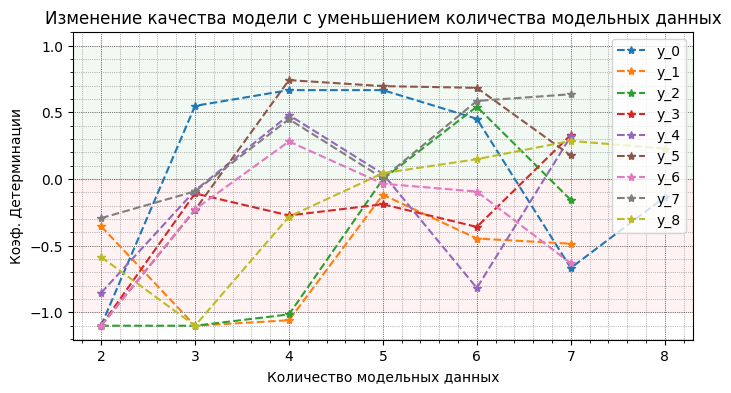

In [14]:
"""
Качество модели при разном числе точек вдоль горизонтальной оси Y на графике (оси X в df)
    Тренировочная выборка - рассматривается первая линия
    Тестовая выборка - оставшиеся точки из 1ой линии
"""
model = 'exponential'



plt.figure(figsize=(8, 4))
plt.title(f'Изменение качества модели с уменьшением количества модельных данных')
plt.xlabel('Количество модельных данных')
plt.ylabel('Коэф. Детерминации')
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.axhspan(0, -1, color='red', alpha=0.05)
plt.axhspan(1, 0, color='green', alpha=0.05)

for i in range(len(list_y)):
    list_y_now = list_y[i]
    list_boreholes_train = get_list_point(list_y_now)
    result_r2_count = {}

    df_now = group_E.query('group == 65')
    df_now = df_now.query('borehole in @list_y_now')
    
    for boreholes_train in list_boreholes_train:
        """
        Разбивка определенных скважин
        """
        data_train = df_now.query('borehole in @boreholes_train')
        data_test = df_now.query('borehole not in @boreholes_train')
    
        if data_test.shape[0] == 0:
            continue
    
        p_train = data_train.loc[:, ["x", "y"]].to_numpy()
        p_test = data_test.loc[:, ["x", "y"]].to_numpy()
        x_train = data_train.loc[:, ["x", "y"]].to_numpy()
        x_test = data_test.loc[:, ["x", "y"]].to_numpy()
        target_train = data_train.loc[:, ["E"]].to_numpy().reshape(-1)
        target_test = data_test.loc[:, ["E"]].to_numpy().reshape(-1)
        
        """
        Кригинг
        """
        x = [0]*x_train[:, 0].shape[0] #x_train[:, 0]
        y = x_train[:, 0]
        E = target_train

        #print(i, len(boreholes_train), len(x), x_train.shape, E.shape)
        OK = UniversalKriging(x, y, E, variogram_model=model, 
                              #variogram_parameters={'sill':28, 'range': 50, 'nugget': 1}
                             )
    
        predict_test, var_test = OK.execute('points', [0]*x_test[:, 0].shape[0], x_test[:, 0])
        result_r2_count[len(boreholes_train)] = [r2_score(target_test, predict_test), my_R2(target_test, predict_test, np.mean(target_train))]

    df_r2_count = pd.DataFrame(result_r2_count, index=["R2", "R2_train"]).applymap(lambda x: round(x, 3)).T
    df_r2_count["count"] = df_r2_count.index
    df_r2_count = df_r2_count.query("count < 9")
    df_r2_count = df_r2_count.applymap(lambda x: -1.1 if x < -1.1 else x)
    
    df_r2_count = df_r2_count.sort_values(by="count")
    plt.plot(df_r2_count["count"], df_r2_count["R2"], "--*", label=f"y_{i}")
    
plt.legend()    
plt.show()

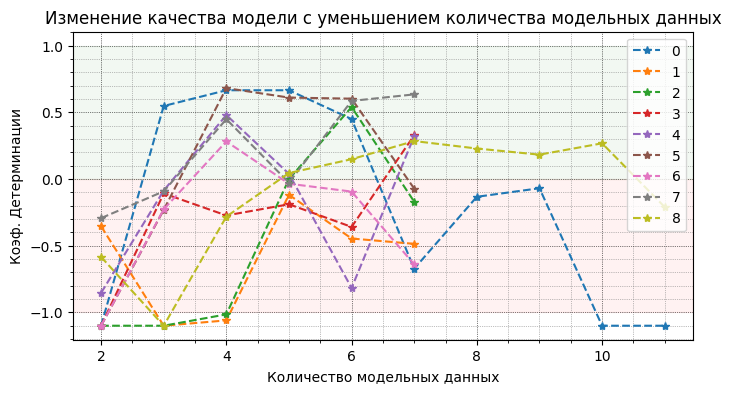

In [84]:
R2Func = R2FunctionForKrigin(group_E.query('group == 65'))
R2Func.show_func(list_y)

## Случай 2, минимальное расположение точек
Рассматриваются точки на соседних рядах  
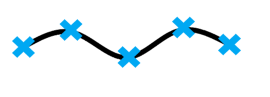

### По оси Х

длина ряда 0+1: 28.05713541449593
длина ряда 1+2: 28.12067889780452
длина ряда 2+3: 28.116301818527464
длина ряда 3+4: 28.105168213817603
длина ряда 4+5: 28.46249087013298
длина ряда 5+6: 28.073204122578776
длина ряда 6+7: 27.938769983068585
длина ряда 7+8: 28.3322220609054


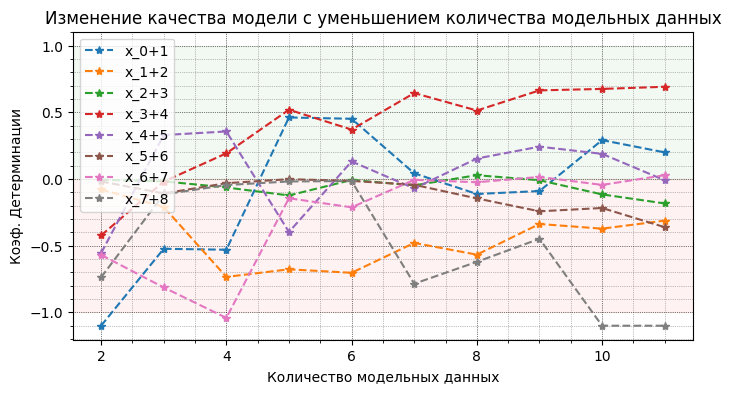

In [90]:
"""
Качество модели при разном числе точек вдоль горизонтальной оси Х на графике (оси Y в df)
    Тренировочная выборка - рассматривается первая линия и вторая линия
    Тестовая выборка - оставшиеся точки из линий
"""
plt.figure(figsize=(8, 4))
plt.title(f'Изменение качества модели с уменьшением количества модельных данных')
plt.xlabel('Количество модельных данных')
plt.ylabel('Коэф. Детерминации')
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.axhspan(0, -1, color='red', alpha=0.05)
plt.axhspan(1, 0, color='green', alpha=0.05)

for i in range(len(list_x)-1):
    """
    Сортировка номеров скважин в двух рядах по расстоянию
    """
    list_x_now = list_x[i] + list_x[i+1]
    points = house_3.query('тсз == @list_x_now').sort_values(by="тсз").reindex(columns=["x", "y", "z", "тсз"])
    list_x_now, max_distance = sort_2d_by_distance(0, points.to_numpy())
    list_x_now = list_x_now[:, -1]
    max_distance *= coeff_dist_Y
    
    df_now = group_E.query('group == 65')
    df_now = df_now.query('borehole in @list_x_now')
    
    result_r2_count = get_dict_R2_for_UK(df_now, list_x_now, variograma='exponential')
    
    df_r2_count = pd.DataFrame(result_r2_count, index=["R2", "R2_train"]).applymap(lambda x: round(x, 3)).T
    df_r2_count["count"] = df_r2_count.index
    df_r2_count = df_r2_count.query("count < 12")
    df_r2_count = df_r2_count.applymap(lambda x: -1.1 if x < -1.1 else x)
    
    df_r2_count = df_r2_count.sort_values(by="count")
    plt.plot(df_r2_count["count"], df_r2_count["R2"], "--*", label=f"x_{i}+{i+1}")
    print(f"длина ряда {i}+{i+1}: {max_distance}")
    
plt.legend()    
plt.show()  

### По оси Y

длина ряда 0+1: 25.017624271247627
длина ряда 1+2: 24.810375108922873
длина ряда 2+3: 25.059905627293446
длина ряда 3+4: 25.17835274726204
длина ряда 4+5: 25.18735025463849
длина ряда 5+6: 24.912302447868402
длина ряда 6+7: 25.392981942915938
длина ряда 7+8: 25.01540862486673


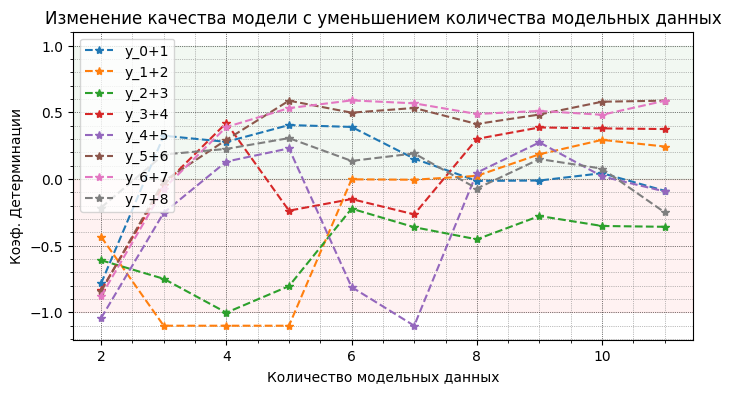

In [91]:
"""
Качество модели при разном числе точек вдоль горизонтальной оси Х на графике (оси Y в df)
    Тренировочная выборка - рассматривается первая линия и вторая линия
    Тестовая выборка - оставшиеся точки из линий
"""
plt.figure(figsize=(8, 4))
plt.title(f'Изменение качества модели с уменьшением количества модельных данных')
plt.xlabel('Количество модельных данных')
plt.ylabel('Коэф. Детерминации')
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.axhspan(0, -1, color='red', alpha=0.05)
plt.axhspan(1, 0, color='green', alpha=0.05)

for i in range(len(list_y)-1):
    """
    Сортировка номеров скважин в двух рядах по расстоянию
    """
    list_y_now = list_y[i] + list_y[i+1]
    points = house_3.query('тсз == @list_y_now').sort_values(by="тсз").reindex(columns=["x", "y", "z", "тсз"])
    list_y_now, max_distance = sort_2d_by_distance(0, points.to_numpy())
    list_y_now = list_y_now[:, -1]
    max_distance *= coeff_dist_X
    
    df_now = group_E.query('group == 65')
    df_now = df_now.query('borehole in @list_y_now')
    
    result_r2_count = get_dict_R2_for_UK(df_now, list_y_now, variograma='exponential')
    
    df_r2_count = pd.DataFrame(result_r2_count, index=["R2", "R2_train"]).applymap(lambda x: round(x, 3)).T
    df_r2_count["count"] = df_r2_count.index
    df_r2_count = df_r2_count.query("count < 12")
    df_r2_count = df_r2_count.applymap(lambda x: -1.1 if x < -1.1 else x)
    
    df_r2_count = df_r2_count.sort_values(by="count")
    plt.plot(df_r2_count["count"], df_r2_count["R2"], "--*", label=f"y_{i}+{i+1}")
    print(f"длина ряда {i}+{i+1}: {max_distance}")
    
plt.legend()    
plt.show()  

## Минимальное колич. точек для случая 3
Расположение точек по X и Y:  
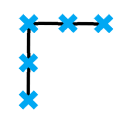

In [116]:
"""
Создание списка скважин для кейса 3
"""
list_case_3 = []

boreholes_x2 = list(range(51, 58)) + [132, 133, 58, 134, 135, 59]
boreholes_y2 = list(range(131, 76, -9)) + [139, 138, 68, 137, 136, 59]
boreholes_x1 = [123, 144, 124, 145, 146, 147] + list(range(126, 131))
boreholes_y1 = [123, 143, 142, 114, 141, 140] + list(range(105, 50, -9))

list_case_3.append(np.unique(boreholes_x2+boreholes_y2[::-1]))
list_case_3.append(np.unique(boreholes_y2[::-1]+boreholes_x1[::-1]))
list_case_3.append(np.unique(boreholes_x1[::-1]+boreholes_y1))
list_case_3.append(np.unique(boreholes_y1+boreholes_x2))

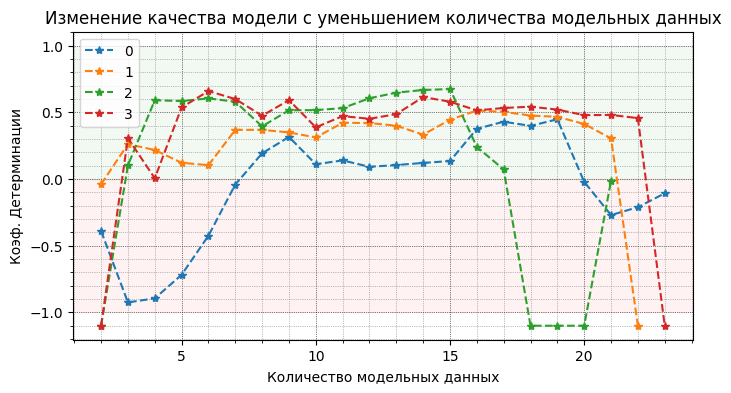

In [117]:
R2Func = R2FunctionForKrigin(group_E.query('group == 65'))
R2Func.show_func(list_case_3)

## Случай 4, минимальное расположение точек
Расположение точек на периметре квадрата  
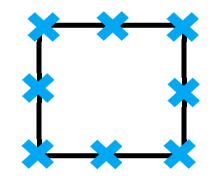

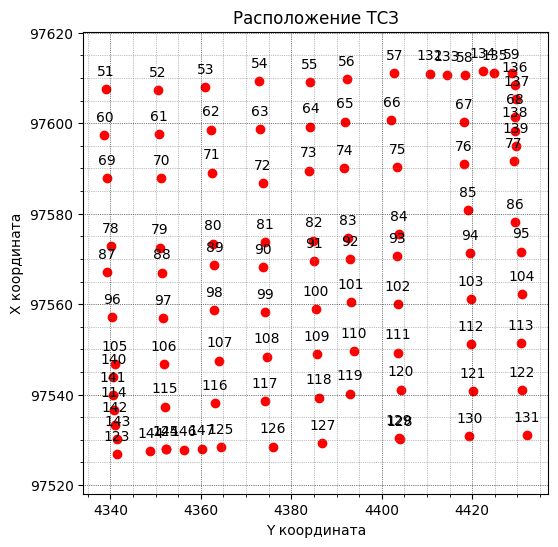

In [130]:
boreholes_line = range(160)

df_now = house_3.query("тсз in @boreholes_line").reset_index(drop=True)

plt.figure(figsize=(6, 6))
y = df_now["x"]
x = df_now["y"]
labels = df_now["тсз"]
for i in range(len(x)):
    plt.scatter(x[i], y[i], label=f'{labels[i]} ({x[i]}, {y[i]})', color="red")
    plt.annotate(labels[i], (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Расположение ТСЗ')
plt.xlabel('Y координата')
plt.ylabel('X координата')
plt.axis('equal')
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.show()

In [126]:
"""
Создание списка скважин для кейса 4
"""
list_case_4 = []

# 8 точек, 3 в ряд, 25.5 м
list_case_4.append(np.unique(list(range(81, 84)) + list(range(83, 102, 9)) + list(range(101, 98, -1)) + list(range(99, 80, -9))))
# 20 точек, 5 в ряд, 51 м
list_case_4.append(np.unique(list(range(71, 76)) + list(range(75, 112, 9)) + list(range(111, 106, -1)) + list(range(107, 70, -9))))
# 28 точек, 7 в ряд, 76.5 м
list_case_4.append(np.unique(list(range(61, 68)) + list(range(67, 122, 9)) + list(range(121, 114, -1)) + list(range(115, 60, -9))))

boreholes_x2 = list(range(51, 58)) + [132, 133, 58, 134, 135, 59]
boreholes_y2 = list(range(131, 76, -9)) + [139, 138, 68, 137, 136, 59]
boreholes_x1 = [123, 144, 124, 145, 146, 147] + list(range(126, 131))
boreholes_y1 = [123, 143, 142, 114, 141, 140] + list(range(105, 50, -9))

# 47 точек, 13 в ряд, 102 м
list_case_4.append(np.unique(boreholes_x2 + boreholes_y2[::-1] + boreholes_x1[::-1] + boreholes_y1))

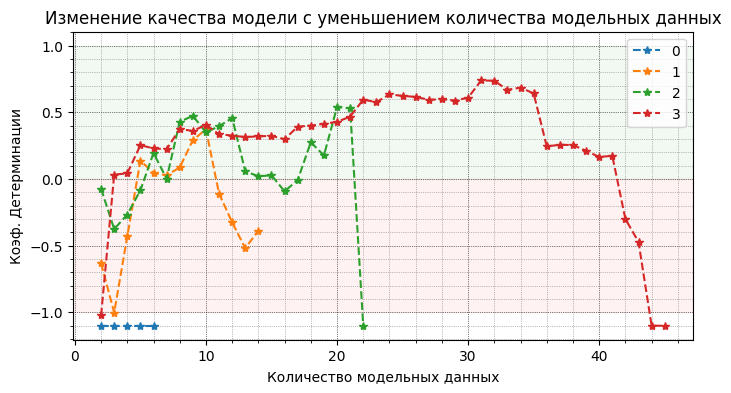

In [128]:
R2Func = R2FunctionForKrigin(group_E.query('group == 65'))
R2Func.show_func(list_case_4)

## Случай 5, минимальное расположение точек
Расположение точек в пределах окружности разного диаметра  
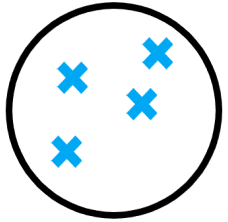

## По всем точкам в плоскости

In [16]:
"""
Качество модели при разном числе точек в плане
    Тренировочная выборка - рассматривается часть точек в плане
    Тестовая выборка - оставшиеся точки в плане
"""
list_boreholes_train = get_list_point(range(51, 132))

model = 'exponential'
df_now = group_E.query('group == 65')

result_r2_count = {}

for boreholes_train in list_boreholes_train:
    """
    Разбивка определенных скважин
    """
    data_train = df_now.query('borehole in @boreholes_train')
    data_test = df_now.query('borehole not in @boreholes_train')

    if data_test.shape[0] == 0:
        continue

    p_train = data_train.loc[:, ["x", "y"]].to_numpy()
    p_test = data_test.loc[:, ["x", "y"]].to_numpy()
    x_train = data_train.loc[:, ["x", "y"]].to_numpy()
    x_test = data_test.loc[:, ["x", "y"]].to_numpy()
    target_train = data_train.loc[:, ["E"]].to_numpy().reshape(-1)
    target_test = data_test.loc[:, ["E"]].to_numpy().reshape(-1)
    """
    Кригинг
    """
    x = x_train[:, 0]
    y = x_train[:, 1]
    E = target_train

    OK = UniversalKriging(x, 
                          y, 
                          E, 
                          variogram_model=model,
                          #variogram_parameters={'sill':28, 'range': 50, 'nugget': 1}
                         )

    predict_test, var_test = OK.execute('points', x_test[:, 0], x_test[:, 1])
    
    #print(target_train.shape, r2_score(target_test, predict_test), my_R2(target_test, predict_test, np.mean(target_train)))
    result_r2_count[len(boreholes_train)] = [r2_score(target_test, predict_test), my_R2(target_test, predict_test, np.mean(target_train))]

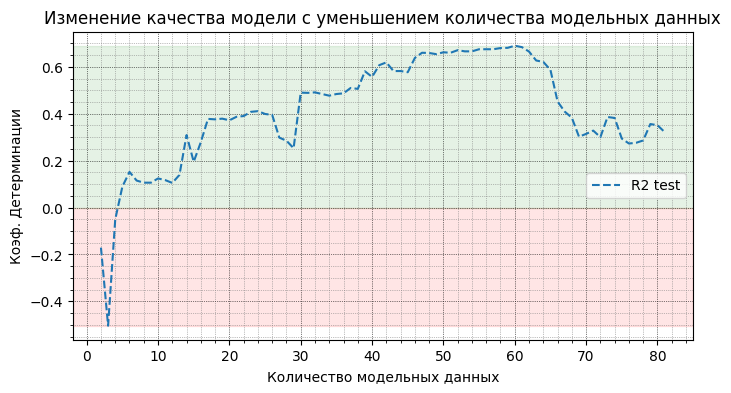

In [17]:
df_r2_count = pd.DataFrame(result_r2_count, index=["R2", "R2_train"]).applymap(lambda x: round(x, 3)).T
df_r2_count["count"] = df_r2_count.index
df_r2_count = df_r2_count.sort_values(by="count")
df_r2_count = df_r2_count.applymap(lambda x: -1.1 if x < -1.1 else x)
#df_r2_count = df_r2_count.query("R2 > 0 & R2_train > 0")

plt.figure(figsize=(8, 4))
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
    
plt.plot(df_r2_count["count"], df_r2_count["R2"], "--", label="R2 test")

plt.axhspan(0, df_r2_count["R2"].min(), color='red', alpha=0.1)
plt.axhspan(df_r2_count["R2"].max(), 0, color='green', alpha=0.1)

plt.legend()    
plt.title(f'Изменение качества модели с уменьшением количества модельных данных')
plt.xlabel('Количество модельных данных')
plt.ylabel('Коэф. Детерминации')
plt.show()

df_r2_uk = df_r2_count.copy()